In [2]:
import pandas as pd
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool

# from notebook_tests.Additional_Results_Investigation_Download import sxr_norms
#from processing_utils import process_file

In [3]:
def normalize_sxr(unnormalized_values, sxr_norm):
    """Convert from unnormalized to normalized space"""
    log_values = np.log10(unnormalized_values + 1e-8)
    normalized = (log_values - float(sxr_norm[0].item())) / float(sxr_norm[1].item())
    return normalized

In [4]:
def unnormalize_sxr(normalized_values, sxr_norm):
    return np.maximum(10 ** (normalized_values * float(sxr_norm[1].item()) + float(sxr_norm[0].item())) - 1e-8, 1e-12)

In [5]:
train = pd.read_csv("/Volumes/T9/FOXES_Data/train_data_combined.csv")
val = pd.read_csv("/Volumes/T9/FOXES_Data/val_data_combined.csv")
test = pd.read_csv("/Volumes/T9/FOXES_Data/test_data_combined.csv")
sxr_norms = np.load('/Volumes/T9/FOXES_Data/SXR/normalized_sxr.npy')

Best alpha: 1e-09
Best Validation MSE (log scale): 0.09921336820751775
Best Alpha: 1e-09
Mean Squared Error (log scale) on Val: 0.09921336820751775
R-squared (log scale) on Val: 0.23965163604380357
Coefficients:
  sum_flux_94: 4.617445969914727e-05
  sum_flux_131: 0.00012852219544852875
  sum_flux_171: -6.037142103742379e-05
  sum_flux_193: 6.30342351118469e-06
  sum_flux_211: -5.829643631790958e-05
  sum_flux_304: 6.725518541976393e-05
  sum_flux_335: 4.986874486803832e-06


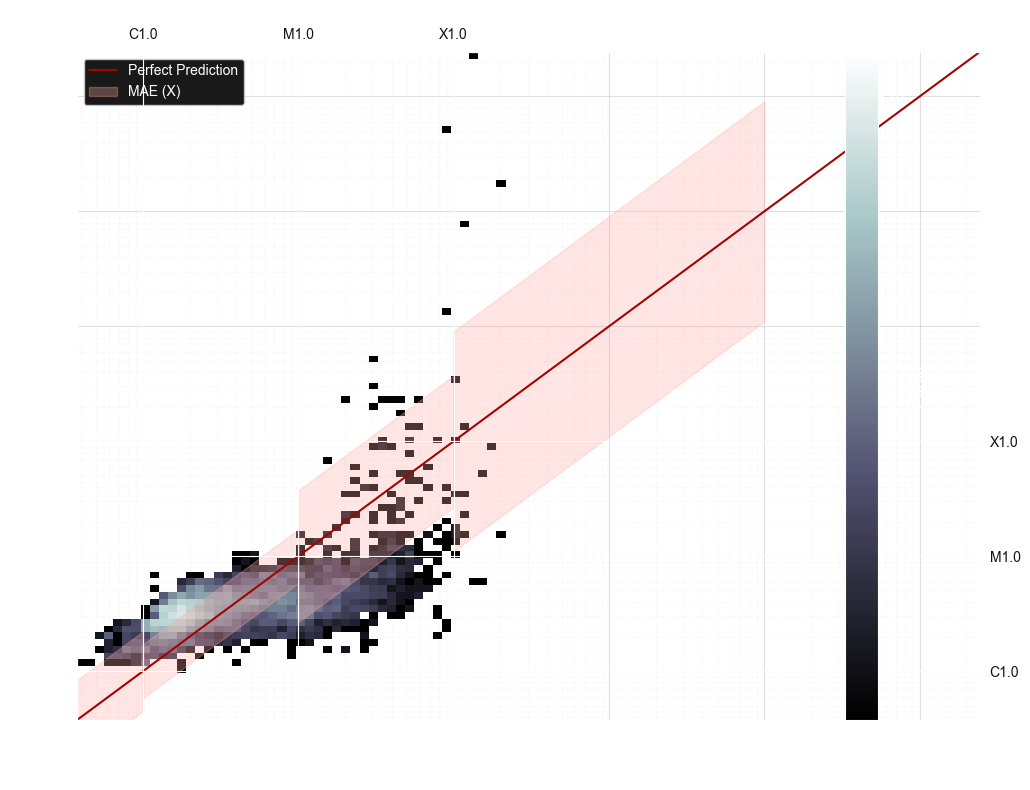

Mean Squared Error (log scale) on Test: 0.14218190789492413
MAE: 0.3071659556351967
R-squared (log scale) on Test: 0.4883162697536606


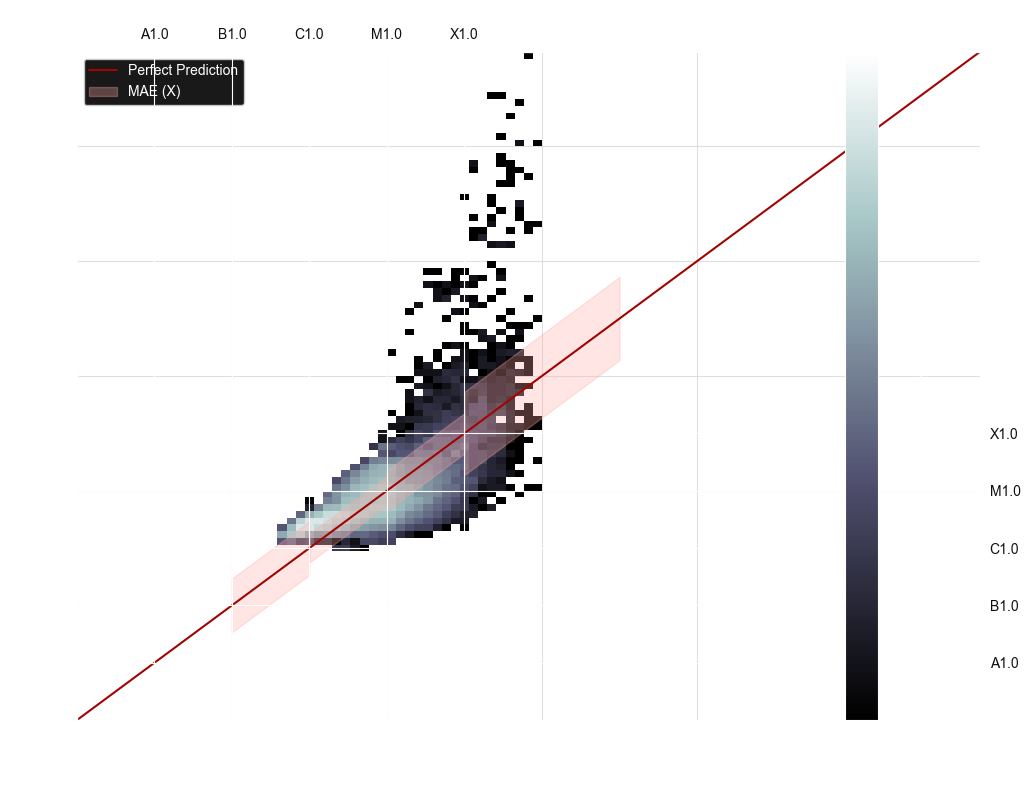

In [29]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Prepare features (X) and target (y)
feature_cols = [f'sum_flux_{w}' for w in ['94', '131', '171', '193', '211', '304', '335']]
X_train = train[feature_cols]
y_train = train['sxr_flux_normalized']

X_val = val[feature_cols]
y_val = val['sxr_flux_normalized']

# Define parameter grid for alpha
param_grid = {'alpha': np.logspace(-9, 1, 50)}

# Optimization on Validation Set
best_alpha = None
best_mse_log = float('inf')
results = []

for alpha in param_grid['alpha']:
    lasso = Lasso(alpha=alpha, random_state=42,max_iter=100000)
    lasso.fit(X_train, y_train)
    y_pred_val = lasso.predict(X_val)

    # Calculate MSE on LOG scale for optimization
    y_pred_val_unnorm = unnormalize_sxr(y_pred_val, sxr_norms)
    y_val_unnorm = np.maximum(val['sxr_flux'], 1e-12)

    y_pred_val_log = np.log10(y_pred_val_unnorm)
    y_val_log = np.log10(y_val_unnorm)

    mse_log = mean_squared_error(y_val_log, y_pred_val_log)
    results.append((alpha, mse_log))

    if mse_log < best_mse_log:
        best_mse_log = mse_log
        best_alpha = alpha

print(f"Best alpha: {best_alpha}")
print(f"Best Validation MSE (log scale): {best_mse_log}")

# Train final model with best alpha on train set
lasso_best = Lasso(alpha=best_alpha, random_state=42)
lasso_best.fit(X_train, y_train)

# %%
# Evaluation on Validation set with best model
y_pred_val = lasso_best.predict(X_val)

# Un-normalize data for analysis
y_val_unnorm = np.maximum(val['sxr_flux'], 1e-12)
y_pred_val_unnorm = unnormalize_sxr(y_pred_val, sxr_norms)

# Calculate metrics in log scale
y_val_log = np.log10(y_val_unnorm)
y_pred_val_log = np.log10(y_pred_val_unnorm)

mse_log = mean_squared_error(y_val_log, y_pred_val_log)
r2_log = r2_score(y_val_log, y_pred_val_log)

# print(f"Best Alpha: {best_alpha}")
# print(f"Mean Squared Error (log scale) on Val: {mse_log}")
# print(f"R-squared (log scale) on Val: {r2_log}")
# print("Coefficients:")
# for col, coef in zip(feature_cols, lasso_best.coef_):
#     print(f"  {col}: {coef}")
# import matplotlib.pyplot as plt
# import matplotlib.ticker as mticker
# from matplotlib.colors import LogNorm
# from sklearn.metrics import mean_absolute_error
# import numpy as np
#
# def plot_regression_results(y_true, y_pred, title, alpha_val):
#     """
#     Generate professional regression plot similar to evaluation.py
#     """
#     # Clip predictions to ensure they're positive for log scale
#     y_pred = np.maximum(y_pred, 1e-12)
#     y_true = np.maximum(y_true, 1e-12)
#
#     # Flare classes for axes
#     flare_classes = {
#         'A1.0': (1e-8, 1e-7),
#         'B1.0': (1e-7, 1e-6),
#         'C1.0': (1e-6, 1e-5),
#         'M1.0': (1e-5, 1e-4),
#         'X1.0': (1e-4, 1e-3)
#     }
#
#     # Theme colors (matching 'white' theme from evaluation.py)
#     axis_facecolor = '#FFFFFF'
#     text_color = '#111111'
#     grid_color = '#CCCCCC'
#     minor_grid_color = '#E6E6E6'
#     figure_facecolor = '#FFFFFF'
#
#     fig, ax = plt.subplots(figsize=(10, 8))
#     fig.patch.set_facecolor(figure_facecolor)
#     ax.set_facecolor(axis_facecolor)
#
#     # Data limits for plotting
#     min_data = min(y_true.min(), y_pred.min())
#     max_data = max(y_true.max(), y_pred.max())
#
#     # Set axis limits with tight padding (ensure positive for log scale)
#     # Using 1e-9 as a reasonable lower bound for solar flux visibility
#     min_val = max(min_data * 0.9, 1e-9)
#     max_val = max_data * 1.1
#
#     # Ensure max > min
#     if max_val <= min_val:
#         max_val = min_val * 10
#
#     log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)
#     norm = LogNorm(vmin=1, vmax=max(10, len(y_true)//10))
#
#     # 2D histogram
#     h = ax.hist2d(y_true, y_pred, bins=[log_bins, log_bins], cmap="bone", norm=norm, cmin=1)
#
#     # Perfect prediction line
#     line_min = min_val
#     line_max = max_val
#     ax.plot([line_min, line_max], [line_min, line_max],
#             label='Perfect Prediction', color='#A00503', linestyle='-', linewidth=1.5, zorder=5)
#
#     # MAE Contours
#     flare_classes_mae = {
#         'A': (1e-8, 1e-7, "#FFAAA5"),
#         'B': (1e-7, 1e-6, "#FFAAA5"),
#         'C': (1e-6, 1e-5, "#FFAAA5"),
#         'M': (1e-5, 1e-4, "#FFAAA5"),
#         'X': (1e-4, 1e-2, "#FFAAA5")
#     }
#
#     for class_name, (min_flux, max_flux, color) in flare_classes_mae.items():
#         mask = (y_true >= min_flux) & (y_true < max_flux)
#         if not np.any(mask):
#             continue
#
#         true_subset = y_true[mask]
#         pred_subset = y_pred[mask]
#
#         # Ensure all values are positive before log transformation
#         pred_subset = np.maximum(pred_subset, 1e-12)
#         true_subset = np.maximum(true_subset, 1e-12)
#
#         # Calculate MAE in log space - now safe from NaN
#         log_mae = mean_absolute_error(np.log10(true_subset), np.log10(pred_subset))
#
#         x_class = np.logspace(np.log10(max(min_flux, min_val)), np.log10(min(max_flux, max_val)), 100)
#         upper_bound = x_class * (10**log_mae)
#         lower_bound = x_class * (10**-log_mae)
#
#         ax.fill_between(x_class, lower_bound, upper_bound, alpha=0.3, color=color,
#                         label=f'MAE ({class_name})' if class_name == 'X' else "")
#
#     # Flare class secondary axes
#     ax_top = ax.twiny()
#     ax_top.set_xlim(ax.get_xlim())
#     ax_top.set_xscale('log')
#
#     ax_right = ax.twinx()
#     ax_right.set_ylim(ax.get_ylim())
#     ax_right.set_yscale('log')
#
#     flare_positions = []
#     flare_labels = []
#     for class_name, (m_flux, _) in flare_classes.items():
#         if m_flux >= min_val and m_flux <= max_val:
#             flare_positions.append(m_flux)
#             flare_labels.append(class_name)
#
#     ax_top.set_xticks(flare_positions)
#     ax_top.set_xticklabels(flare_labels, fontsize=10, color=text_color)
#     ax_right.set_yticks(flare_positions)
#     ax_right.set_yticklabels(flare_labels, fontsize=10, color=text_color)
#
#     # Labels and Scaling
#     ax.set_xlabel('Actual SXR Flux (W/m$^2$)', fontsize=12)
#     ax.set_ylabel('Predicted SXR Flux (W/m$^2$)', fontsize=12)
#     ax.set_title(title, fontsize=14, pad=20)
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#
#     # Use tighter limits for axis display
#     ax.set_xlim(min_val, max_val)
#     ax.set_ylim(min_val, max_val)
#
#     ax.grid(True, which="major", ls="-", alpha=0.6, color=grid_color)
#     ax.grid(True, which="minor", ls="--", alpha=0.2, color=minor_grid_color)
#     ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto', numticks=10))
#     ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto', numticks=10))
#
#     # Colorbar
#     cbar = fig.colorbar(h[3], ax=ax, orientation='vertical', pad=0.08)
#     cbar.set_label("Count", fontsize=12)
#
#     ax.legend(loc='upper left', frameon=True, framealpha=0.9)
#
#     plt.tight_layout()
#     plt.show()
#
#
# # Evaluation on Validation set with best model
# y_pred_val = lasso_best.predict(X_val)
# y_val_unnorm = np.maximum(val['sxr_flux'], 1e-12)
# y_pred_val_unnorm = unnormalize_sxr(y_pred_val, sxr_norms)
#
# plot_regression_results(y_val_unnorm, y_pred_val_unnorm,
#                        f'Optimized Lasso (alpha={best_alpha:.2e}): Actual vs Predicted (Validation Set)',
#                        best_alpha)
#
# # %%
# # Evaluation on Test set
# X_test = test[feature_cols]
# y_test = test['sxr_flux_normalized']
#
# y_pred_test = lasso_best.predict(X_test)
#
# # Un-normalize data for analysis
# y_test_unnorm = np.maximum(test['sxr_flux'], 1e-12)
# y_pred_test_unnorm = unnormalize_sxr(y_pred_test, sxr_norms)
#
# # Ensure values are positive before log transformation to avoid NaN/inf
# y_test_log = np.log10(np.clip(y_test_unnorm, a_min=1e-12, a_max=None))
# y_pred_test_log = np.log10(np.clip(y_pred_test_unnorm, a_min=1e-12, a_max=None))
#
# # Now calculate metrics safely
# mse_test_log = mean_squared_error(y_test_log, y_pred_test_log)
# rmse = np.sqrt(mse_test_log)
# mae = mean_absolute_error(y_test_log, y_pred_test_log)
# r2_test_log = r2_score(y_test_log, y_pred_test_log)
#
# print(f"Mean Squared Error (log scale) on Test: {mse_test_log}")
# print(f"MAE: {mae}")
# print(f"R-squared (log scale) on Test: {r2_test_log}")
#
# # %%
# plot_regression_results(y_test_unnorm, y_pred_test_unnorm,
#                        f'Optimized Lasso (alpha={best_alpha:.2e}): Actual vs Predicted (Test Set)',
#                        best_alpha)

# %%


Weight scheme: custom
Class distribution and weights:
  A:   1265 samples, weight=1.0000
  B:  10447 samples, weight=2.0000
  C:  47824 samples, weight=5.0000
  M:  16469 samples, weight=10.0000
  X:   1804 samples, weight=20.0000

Optimizing alpha parameter...
Testing alpha 1/50: 1.00e-09
Testing alpha 11/50: 1.10e-07
Testing alpha 21/50: 1.21e-05
Testing alpha 31/50: 1.33e-03
Testing alpha 41/50: 1.46e-01

Best alpha: 10.0
Best Validation MSE (log scale): 0.10253077738575019

--- Validation Results ---
Best Alpha: 10.0
Mean Squared Error (log scale) on Val: 0.10253077738575019
R-squared (log scale) on Val: 0.2142277774770185

Coefficients:
  sum_flux_94: 6.0570361899429543e-05
  sum_flux_131: 7.298394659408244e-05
  sum_flux_171: -3.296713662701677e-05
  sum_flux_193: -2.094391907679821e-06
  sum_flux_211: -5.7746949924382385e-05
  sum_flux_304: 4.040944189184439e-05
  sum_flux_335: 1.3158285200210157e-05

--- Per-Class Performance (Validation) ---
  Class B: MSE=0.2045, MAE=0.4388,

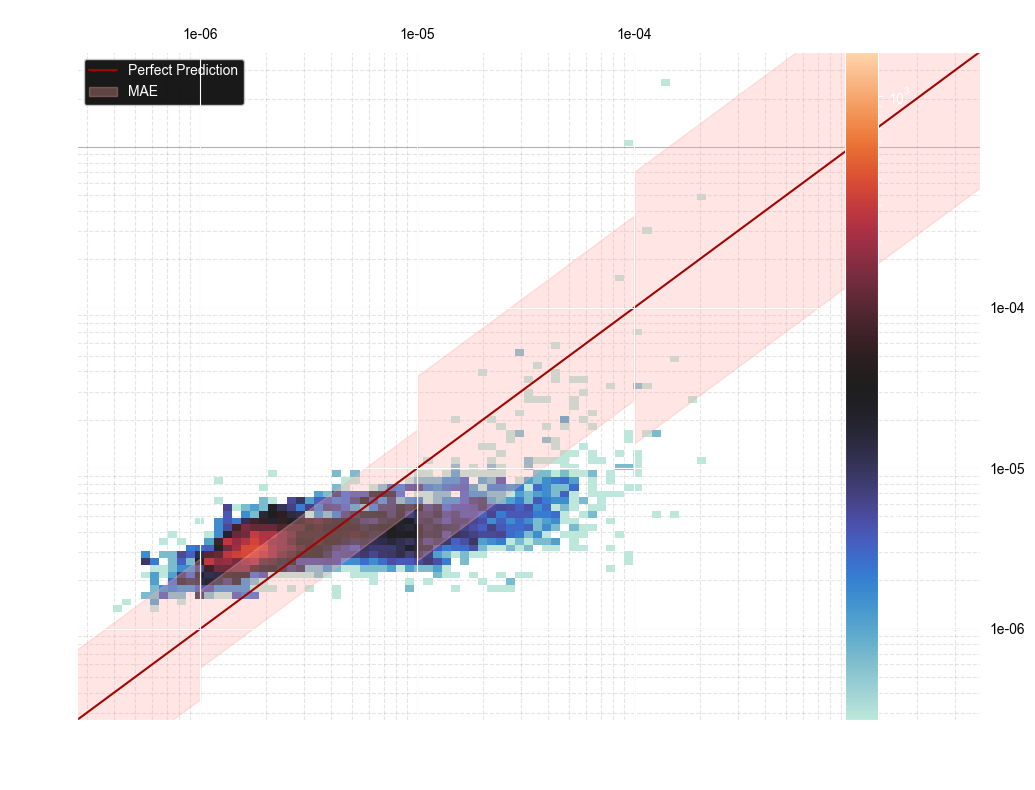

Generating test set plot...


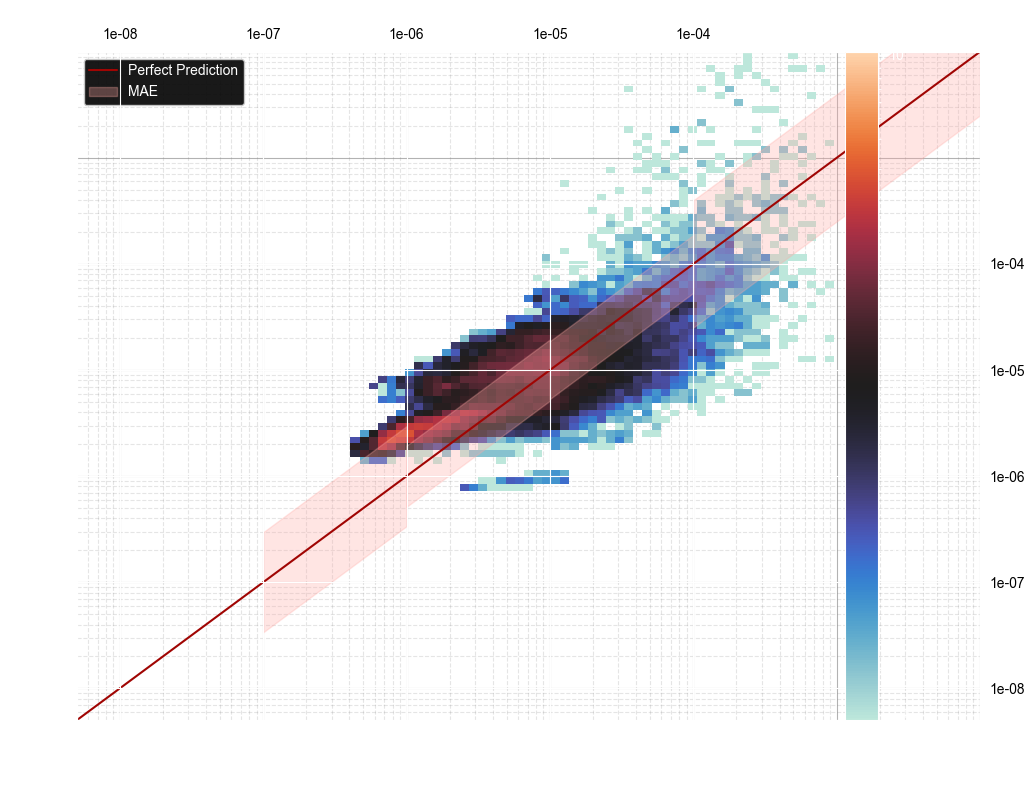

In [40]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Prepare features (X) and target (y)
feature_cols = [f'sum_flux_{w}' for w in ['94', '131', '171', '193', '211', '304', '335']]
X_train = train[feature_cols]
y_train = train['sxr_flux_normalized']

X_val = val[feature_cols]
y_val = val['sxr_flux_normalized']

# Define flare class boundaries (in unnormalized W/m^2)
def get_flare_class(sxr_flux):
    """
    Assign flare class based on SXR flux
    Returns: 'A', 'B', 'C', 'M', or 'X'
    """
    flux = np.abs(sxr_flux)
    if flux < 1e-7:
        return 'A'
    elif flux < 1e-6:
        return 'B'
    elif flux < 1e-5:
        return 'C'
    elif flux < 1e-4:
        return 'M'
    else:
        return 'X'

def compute_sample_weights(sxr_flux, weight_scheme='balanced'):
    """
    Compute sample weights based on flare class
    
    Parameters:
    -----------
    sxr_flux : array-like
        SXR flux values (unnormalized)
    weight_scheme : str
        'balanced' - inversely proportional to class frequency
        'custom' - manually defined weights favoring higher classes
        'sqrt_balanced' - square root of inverse frequency (less extreme)
    
    Returns:
    --------
    weights : array
        Sample weights for each instance
    """
    # Assign flare classes
    classes = np.array([get_flare_class(f) for f in sxr_flux])
    
    if weight_scheme == 'balanced':
        # Compute class frequencies
        unique_classes, counts = np.unique(classes, return_counts=True)
        class_weights = {cls: len(classes) / (len(unique_classes) * count) 
                        for cls, count in zip(unique_classes, counts)}
    
    elif weight_scheme == 'sqrt_balanced':
        # Less extreme version of balanced
        unique_classes, counts = np.unique(classes, return_counts=True)
        class_weights = {cls: np.sqrt(len(classes) / (len(unique_classes) * count))
                        for cls, count in zip(unique_classes, counts)}
    
    elif weight_scheme == 'custom':
        # Custom weights: prioritize M and X class flares
        class_weights = {
            'A': 1.0,
            'B': 2.0,
            'C': 5.0,
            'M': 10.0,
            'X': 20.0
        }
    
    else:
        raise ValueError(f"Unknown weight_scheme: {weight_scheme}")
    
    # Map weights to samples
    weights = np.array([class_weights[cls] for cls in classes])
    
    # Print weight statistics
    print(f"\nWeight scheme: {weight_scheme}")
    print("Class distribution and weights:")
    for cls in ['A', 'B', 'C', 'M', 'X']:
        mask = classes == cls
        if np.any(mask):
            print(f"  {cls}: {np.sum(mask):6d} samples, weight={class_weights[cls]:.4f}")
    
    return weights

# Compute sample weights for training set
# Try different schemes: 'balanced', 'sqrt_balanced', 'custom'
train_weights = compute_sample_weights(train['sxr_flux'], weight_scheme='custom')

# Define parameter grid for alpha
param_grid = {'alpha': np.logspace(-9, 1, 50)}

# Optimization on Validation Set with weighted training
best_alpha = None
best_mse_log = float('inf')
results = []

print("\nOptimizing alpha parameter...")
for i, alpha in enumerate(param_grid['alpha']):
    if i % 10 == 0:
        print(f"Testing alpha {i+1}/{len(param_grid['alpha'])}: {alpha:.2e}")
    
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=100000)
    # Fit with sample weights
    lasso.fit(X_train, y_train, sample_weight=train_weights)
    y_pred_val = lasso.predict(X_val)
    
    # Calculate MSE on LOG scale for optimization
    y_pred_val_unnorm = unnormalize_sxr(y_pred_val, sxr_norms)
    y_val_unnorm = np.maximum(val['sxr_flux'], 1e-12)
    
    # Clip predictions to avoid log(0) or log(negative)
    y_pred_val_unnorm = np.maximum(y_pred_val_unnorm, 1e-12)
    
    y_pred_val_log = np.log10(y_pred_val_unnorm)
    y_val_log = np.log10(y_val_unnorm)
    
    mse_log = mean_squared_error(y_val_log, y_pred_val_log)
    results.append((alpha, mse_log))
    
    if mse_log < best_mse_log:
        best_mse_log = mse_log
        best_alpha = alpha

print(f"\nBest alpha: {best_alpha}")
print(f"Best Validation MSE (log scale): {best_mse_log}")

# Train final model with best alpha on train set
lasso_best = Lasso(alpha=best_alpha, random_state=42, max_iter=100000)
lasso_best.fit(X_train, y_train, sample_weight=train_weights)

# Evaluation on Validation set with best model
y_pred_val = lasso_best.predict(X_val)

# Un-normalize data for analysis
y_val_unnorm = np.maximum(val['sxr_flux'], 1e-12)
y_pred_val_unnorm = np.maximum(unnormalize_sxr(y_pred_val, sxr_norms), 1e-12)

# Calculate metrics in log scale
y_val_log = np.log10(y_val_unnorm)
y_pred_val_log = np.log10(y_pred_val_unnorm)

mse_log = mean_squared_error(y_val_log, y_pred_val_log)
r2_log = r2_score(y_val_log, y_pred_val_log)

print(f"\n--- Validation Results ---")
print(f"Best Alpha: {best_alpha}")
print(f"Mean Squared Error (log scale) on Val: {mse_log}")
print(f"R-squared (log scale) on Val: {r2_log}")
print("\nCoefficients:")
for col, coef in zip(feature_cols, lasso_best.coef_):
    print(f"  {col}: {coef}")

# Calculate per-class performance on validation set
print("\n--- Per-Class Performance (Validation) ---")
val_classes = np.array([get_flare_class(f) for f in val['sxr_flux']])
for cls in ['A', 'B', 'C', 'M', 'X']:
    mask = val_classes == cls
    if np.any(mask):
        cls_mse = mean_squared_error(y_val_log[mask], y_pred_val_log[mask])
        cls_mae = mean_absolute_error(y_val_log[mask], y_pred_val_log[mask])
        cls_r2 = r2_score(y_val_log[mask], y_pred_val_log[mask])
        print(f"  Class {cls}: MSE={cls_mse:.4f}, MAE={cls_mae:.4f}, R²={cls_r2:.4f}, n={np.sum(mask)}")

# ===== TEST SET EVALUATION =====
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

# Prepare test data
X_test = test[feature_cols]
y_test = test['sxr_flux_normalized']

# Make predictions on test set
y_pred_test = lasso_best.predict(X_test)

# Un-normalize data for analysis
y_test_unnorm = np.maximum(test['sxr_flux'], 1e-12)
y_pred_test_unnorm = np.maximum(unnormalize_sxr(y_pred_test, sxr_norms), 1e-12)

# Calculate metrics in log scale
y_test_log = np.log10(y_test_unnorm)
y_pred_test_log = np.log10(y_pred_test_unnorm)

mse_test_log = mean_squared_error(y_test_log, y_pred_test_log)
rmse_test_log = np.sqrt(mse_test_log)
mae_test_log = mean_absolute_error(y_test_log, y_pred_test_log)
r2_test_log = r2_score(y_test_log, y_pred_test_log)

print(f"\n--- Overall Test Results ---")
print(f"Mean Squared Error (log scale): {mse_test_log:.6f}")
print(f"Root Mean Squared Error (log scale): {rmse_test_log:.6f}")
print(f"Mean Absolute Error (log scale): {mae_test_log:.6f}")
print(f"R-squared (log scale): {r2_test_log:.6f}")

# Calculate per-class performance on test set
print("\n--- Per-Class Performance (Test) ---")
test_classes = np.array([get_flare_class(f) for f in test['sxr_flux']])
for cls in ['A', 'B', 'C', 'M', 'X']:
    mask = test_classes == cls
    if np.any(mask):
        cls_mse = mean_squared_error(y_test_log[mask], y_pred_test_log[mask])
        cls_mae = mean_absolute_error(y_test_log[mask], y_pred_test_log[mask])
        cls_r2 = r2_score(y_test_log[mask], y_pred_test_log[mask])
        print(f"  Class {cls}: MSE={cls_mse:.4f}, MAE={cls_mae:.4f}, R²={cls_r2:.4f}, n={np.sum(mask)}")

# Compare validation vs test performance
print("\n--- Validation vs Test Comparison ---")
print(f"{'Metric':<25} {'Validation':<15} {'Test':<15} {'Difference':<15}")
print("-" * 70)
print(f"{'MSE (log scale)':<25} {mse_log:<15.6f} {mse_test_log:<15.6f} {mse_test_log - mse_log:<15.6f}")
print(f"{'R² (log scale)':<25} {r2_log:<15.6f} {r2_test_log:<15.6f} {r2_test_log - r2_log:<15.6f}")

# ===== VISUALIZATION =====
print("\n" + "="*60)
print("GENERATING PLOTS")
print("="*60)

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm

def plot_regression_results(y_true, y_pred, title, alpha_val):
    """
    Generate professional regression plot with 2D histogram
    """
    # Clip predictions to ensure they're positive for log scale
    y_pred = np.maximum(y_pred, 1e-12)
    y_true = np.maximum(y_true, 1e-12)
    
    # Flare classes for axes
    flare_classes = {
        'A1.0': (1e-8, 1e-7),
        'B1.0': (1e-7, 1e-6),
        'C1.0': (1e-6, 1e-5),
        'M1.0': (1e-5, 1e-4),
        'X1.0': (1e-4, 1e-3)
    }

    # Theme colors
    axis_facecolor = 'white'
    text_color = 'black'
    grid_color = 'grey'
    minor_grid_color = 'grey'
    figure_facecolor = 'white'

    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor(figure_facecolor)
    ax.set_facecolor(axis_facecolor)

    # Set axis limits to tightly fit the data
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    
    # Enforce realistic minimum at 1e-8 (A1.0 flare class threshold)
    min_val = max(min_val, 1e-8)
    
    # Enforce realistic maximum at 1e-2 (beyond X10 class)
    max_val = min(max_val, 1e-2)
    
    # Add small buffer (5% on log scale) instead of 10%
    log_range = np.log10(max_val) - np.log10(min_val)
    buffer = 0.05 * log_range  # 5% buffer
    
    min_val = 10 ** (np.log10(min_val) - buffer)
    max_val = 10 ** (np.log10(max_val) + buffer)
    
    # Ensure limits stay within realistic bounds after buffer, but allow a bit below 1e-8 for padding
    min_val = max(min_val, 0.5e-8)
    max_val = min(max_val, 1e-2)
    
    log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)
    norm = LogNorm(vmin=1, vmax=max(10, len(y_true)//10))

    # 2D histogram
    cmap = plt.get_cmap("icefire").copy()
    h = ax.hist2d(y_true, y_pred, bins=[log_bins, log_bins], cmap=cmap, norm=norm)

    # Perfect prediction line
    ax.plot([min_val, max_val], [min_val, max_val], 
            label='Perfect Prediction', color='#A00503', linestyle='-', linewidth=1.5, zorder=5)

    # MAE Contours
    flare_classes_mae = {
        'A': (1e-8, 1e-7, "#FFAAA5"),
        'B': (1e-7, 1e-6, "#FFAAA5"),
        'C': (1e-6, 1e-5, "#FFAAA5"),
        'M': (1e-5, 1e-4, "#FFAAA5"),
        'X': (1e-4, 1e-2, "#FFAAA5")
    }

    for class_name, (min_flux, max_flux, color) in flare_classes_mae.items():
        mask = (y_true >= min_flux) & (y_true < max_flux)
        if not np.any(mask):
            continue

        true_subset = y_true[mask]
        pred_subset = y_pred[mask]
        
        # Ensure all values are positive before log transformation
        pred_subset = np.maximum(pred_subset, 1e-12)
        true_subset = np.maximum(true_subset, 1e-12)

        # Calculate MAE in log space
        log_mae = mean_absolute_error(np.log10(true_subset), np.log10(pred_subset))

        x_class = np.logspace(np.log10(max(min_flux, min_val)), np.log10(min(max_flux, max_val)), 100)
        upper_bound = x_class * (10**log_mae)
        lower_bound = x_class * (10**-log_mae)

        ax.fill_between(x_class, lower_bound, upper_bound, alpha=0.3, color=color, 
                        label=f'MAE' if class_name == 'X' else "")

    # Flare class secondary axes
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xscale('log')
    
    ax_right = ax.twinx()
    ax_right.set_ylim(ax.get_ylim())
    ax_right.set_yscale('log')

    flare_positions = []
    flare_labels = []
    for class_name, (m_flux, _) in flare_classes.items():
        if m_flux >= min_val and m_flux <= max_val:
            flare_positions.append(m_flux)
            flare_labels.append(f"{m_flux:.0e}")

    ax_top.set_xticks(flare_positions)
    ax_top.set_xticklabels(flare_labels, fontsize=10, color=text_color)
    ax_right.set_yticks(flare_positions)
    ax_right.set_yticklabels(flare_labels, fontsize=10, color=text_color)

    # Labels and Scaling
    ax.set_xlabel('Actual SXR Flux (W/m$^2$)', fontsize=12)
    ax.set_ylabel('Predicted SXR Flux (W/m$^2$)', fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)

    ax.grid(True, which="major", ls="-", alpha=0.6, color=grid_color)
    ax.grid(True, which="minor", ls="--", alpha=0.2, color=minor_grid_color)
    ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto', numticks=10))
    ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto', numticks=10))

    # Colorbar
    cbar = fig.colorbar(h[3], ax=ax, orientation='vertical', pad=0.15)
    cbar.set_label("Count", fontsize=12)

    ax.legend(loc='upper left', frameon=True, framealpha=0.9)
    
    plt.tight_layout()
    plt.show()

# Plot validation results
print("\nGenerating validation set plot...")
plot_regression_results(y_val_unnorm, y_pred_val_unnorm, 
                       f'Weighted Lasso (alpha={best_alpha:.2e}): Validation Set', 
                       best_alpha)

# Plot test results
print("Generating test set plot...")
plot_regression_results(y_test_unnorm, y_pred_test_unnorm, 
                       f'Weighted Lasso (alpha={best_alpha:.2e}): Test Set', 
                       best_alpha)